#### **Library**

In [ ]:
import os
import warnings
import pandas as pd
import numpy as np
from pathlib import Path
# from google.colab import userdata
warnings.filterwarnings('ignore')

In [10]:
[c for c in range(100, 1000, 250)]

[100, 350, 600, 850]

In [14]:
[round(c, 2) for c in np.linspace(0.01, 2, 4)]
# [c for c in range(10, 200, 30)]

[0.01, 0.67, 1.34, 2.0]

#### **Load Dataset**

In [2]:
# File paths
PATH = Path(os.path.abspath("..")) / "data/processed"
FILE_PATH = os.path.join(PATH, "covid19_tweets.csv")

# Load processed dataset
pd.set_option("display.max_colwidth", None)

df = pd.read_csv(FILE_PATH) \
    .dropna() \
    .reset_index(drop=True) \
    .drop("tweet", axis=1)

df.head()

,text,sentiment
0,latest driver country gas price drop amid,negative
1,difficult time moment stockpile panic buy buy normal plenty food essential supply thinkofothers especially elderly dontbeselfish,positive
2,buy gift certificate online shopping time local business alive book book,positive
3,rental price fall time decade realestate investment,neutral
4,rotorua shopper wear beekeeping suit supermarket,neutral


#### **Train & Test Split**

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def split_data(df, test_size=0.2, random_state=43):

    X_all = df[["text"]]
    y_all = df[["sentiment"]]

    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=test_size, random_state=random_state, stratify=y_all
    )

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(df)

In [4]:
# Load split data
train_ = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
test_ = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

train_.to_csv("../data/splits/train.csv", index=False)
test_.to_csv("../data/splits/test.csv", index=False)

#### **Model Development & Selection**

In [281]:
# Load train/test split data
def load_train_split(file_name: str) -> pd.DataFrame:
    """ Load train/test dataset from splits folder.
    params: File path
    returns: pandas dataframe
    """
    PATH = Path(os.path.abspath("..")) / "data/splits"
    FILE_PATH = os.path.join(PATH, file_name)
    df = pd.read_csv(FILE_PATH)
    return df

# Load training dataset for model training
dataset = load_train_split("train.csv")

X_all= dataset[["text"]]
y_all = dataset[["sentiment"]]

In [ ]:
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, roc_auc_score

# ML: Algorithms
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [283]:
# Calculate model metrics and output as a dictionary of those metrics
def calculate_model_metrics(model: BaseEstimator, X_values: pd.DataFrame, y_true: list) -> dict:

    f1 = f1_score(y_true, model.predict(X_values), average="weighted")
    roc_auc =  roc_auc_score(y_true, model.predict_proba(X_values),  average="weighted", multi_class="ovo")

    metrics = dict(f1=np.round(f1, 2), roc_auc=np.round(roc_auc, 2))
    return metrics

In [284]:
import time
from datetime import timedelta

# TFIDf token function
def word_processor(doc: str):
    return doc

def calculate_average_cv(metrics:list, alias="train") -> dict:
    """Calculates the average cross-validation scores.
    params: metrics - list of cv metrics
    returns: average cv scores
    """
    keys = list(next(iter(metrics)))
    values = [list(score.values()) for score in metrics]
    score_avg = np.mean(values, axis=0)
    cv_metrics = {f"{alias}_{n}": np.round(v, 2) for n, v in zip(keys, score_avg)}
    cv_scores = {f"{alias}_avg": np.round(np.mean(score_avg), 2), **cv_metrics}
    
    return cv_scores 


def cross_validation_func(baseline: BaseEstimator, X: pd.DataFrame, y: pd.DataFrame) -> dict:
    
    label_encoding = LabelEncoder()
    y_all_ = label_encoding.fit_transform(y)

    # pipeline Implementation
    vect = TfidfVectorizer(
        analyzer="word",
        tokenizer=word_processor,
        preprocessor=word_processor
    )

    ct = make_column_transformer((vect, "text"), remainder="drop")
    pipeline = make_pipeline(ct, baseline)

    # Cross-Validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)

    train_scores = []
    val_scores = []
    time_start = time.time()
    time_lapsed = None

    for idx, (train_idx, val_idx) in tqdm(enumerate(cv.split(X, y_all))):

        print(" Iteration Count:", idx+1)
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y_all_[train_idx], y_all_[val_idx]

        pipeline.fit(X_train_fold, y_train_fold)

        train_score = calculate_model_metrics(pipeline, X_train_fold, y_train_fold)
        val_score = calculate_model_metrics(pipeline, X_val_fold, y_val_fold)
        
        train_scores.append(train_score)
        val_scores.append(val_score)
        time_lapsed = time.time() - time_start

    # Training time-lapsed
    seconds = np.round(time_lapsed)
    total_time = str(timedelta(seconds=seconds))

    # Cross-validated metric scores
    training_score = calculate_average_cv(train_scores)
    validation_score = calculate_average_cv(val_scores, "val")
    metric_scores = dict(**training_score, **validation_score, time_lapsed=total_time)
    
    return metric_scores

In [285]:
baseline = DecisionTreeClassifier(random_state=43)
knn_scores = cross_validation_func(baseline, X_all, y_all)

0it [00:00, ?it/s]

 Iteration Count: 1


1it [00:04,  4.20s/it]

 Iteration Count: 2


2it [00:07,  3.95s/it]

 Iteration Count: 3


3it [00:11,  3.80s/it]

 Iteration Count: 4


4it [00:14,  3.63s/it]

 Iteration Count: 5


5it [00:18,  3.71s/it]


In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# Barplots for metric comparisons
def plot_cv_scores(scores: dict) -> None:
    
    filter_metric = [
        (c.split('_')[0], "_".join(c.split("_")[1:]), k)
        if len(c.split('_')) > 2 else (*c.split('_'), k) 
        for c, k in scores.items() if "time" not in c
    ]

    cols = ["cv", "x", "y"]
    metric_df = pd.DataFrame(filter_metric, columns=cols) \
            .sort_values("x", ascending=False)

    # Seaborn plot
    _, ax = plt.subplots(figsize=(10, 4))
    plt.style.use("ggplot")
    
    sns.barplot(metric_df, x="x", y="y", width=0.5, hue="cv", palette="colorblind", ax=ax)
    # Axis Labels and Title
    ax.set_title("cross validation metrics", fontsize=12, alpha=0.8)
    ax.set_ylabel("score", fontsize=12)
    ax.set_xlabel("")
    plt.legend(title="")

    ax.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

In [288]:
knn_scores

{'train_avg': 1.0,
 'train_f1': 1.0,
 'train_roc_auc': 1.0,
 'val_avg': 0.49,
 'val_f1': 0.42,
 'val_roc_auc': 0.55,
 'time_lapsed': '0:00:19'}

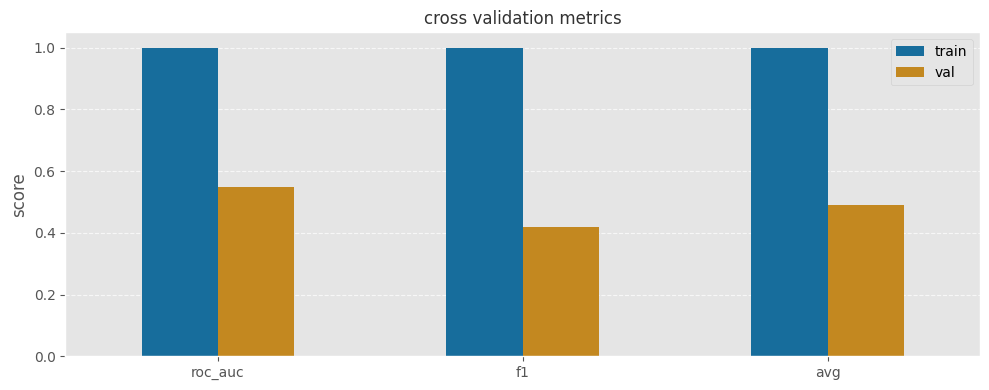

In [289]:
plot_cv_scores(knn_scores)

In [ ]:
# ToDo: Interpret the results (Does the model generalize well on unseen data?)

#### **Hyper-Optimizer**

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold


def hyper_optimizer(baseline: BaseEstimator, parameters: dict, cv_splits=3) -> pd.DataFrame:
    
    # pipeline Implementation
    vect = TfidfVectorizer(
        ngram_range=(1,1),
        norm="l2",
        analyzer="word",
        tokenizer=word_processor,
        preprocessor=word_processor
    )
    ct = make_column_transformer((vect, "text"), remainder="drop")
    pipeline = make_pipeline(ct, baseline)

    # Define KFlod 
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=43)
    
    # Model pipeline parameters 
    max_ngram = 4
    min_ngram = 1
    ngram_ranges = [
        (i,j) for i in range(min_ngram, max_ngram + 1) 
        for j in range(min_ngram, max_ngram + 1)]
    
    params = [{"columntransformer__tfidfvectorizer__ngram_range": ngram_ranges,
            "columntransformer__tfidfvectorizer__norm": ["l1", "l2"]}, parameters]

    # Label Encoding
    label_encoding = LabelEncoder()
    y_all_ = label_encoding.fit_transform(y_all)

    # All pipeline paramters
    model_params = {
        "cv": cv,
        "n_jobs": -1,
        "verbose": 1,
        "param_grid": params,
        "refit": "roc_auc_ovo",
        "scoring": ("f1_weighted", "roc_auc_ovo"),
    }

    # Parameter optimization
    cv_pipe = GridSearchCV(pipeline, **model_params) \
        .fit(X_all, y_all_)

    selected_cols = [
        "params", 
        "mean_test_f1_weighted", 
        "mean_test_roc_auc_ovo",
        "rank_test_roc_auc_ovo"
    ]
    
    pd.set_option("display.max_colwidth", None)
    cv_result_df = pd.DataFrame(cv_pipe.cv_results_)[selected_cols]
    cv_result_df = cv_result_df.sort_values("rank_test_roc_auc_ovo")
    
    return cv_result_df


In [ ]:
params = {
    "decisiontreeclassifier__criterion": ["gini", "entropy", "log_loss"],
    "decisiontreeclassifier__max_depth": [10, 50, 100, 500, 1000],
    "decisiontreeclassifier__max_features": ["sqrt", "log2"]
}

tune_results = hyper_optimizer(baseline, params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [25]:
tune_results

,params,mean_test_f1_weighted,mean_test_roc_auc_ovo,rank_test_roc_auc_ovo
18,"{'columntransformer__tfidfvectorizer__ngram_range': (4, 4), 'columntransformer__tfidfvectorizer__norm': 'l1'}",0.484578,0.590644,1
19,"{'columntransformer__tfidfvectorizer__ngram_range': (4, 4), 'columntransformer__tfidfvectorizer__norm': 'l2'}",0.482392,0.585425,2
17,"{'columntransformer__tfidfvectorizer__ngram_range': (3, 4), 'columntransformer__tfidfvectorizer__norm': 'l2'}",0.466723,0.579886,3
11,"{'columntransformer__tfidfvectorizer__ngram_range': (3, 3), 'columntransformer__tfidfvectorizer__norm': 'l2'}",0.459877,0.571032,4
16,"{'columntransformer__tfidfvectorizer__ngram_range': (3, 4), 'columntransformer__tfidfvectorizer__norm': 'l1'}",0.465304,0.570773,5
7,"{'columntransformer__tfidfvectorizer__ngram_range': (1, 3), 'columntransformer__tfidfvectorizer__norm': 'l2'}",0.447828,0.569176,6
14,"{'columntransformer__tfidfvectorizer__ngram_range': (2, 4), 'columntransformer__tfidfvectorizer__norm': 'l1'}",0.457097,0.568067,7
10,"{'columntransformer__tfidfvectorizer__ngram_range': (3, 3), 'columntransformer__tfidfvectorizer__norm': 'l1'}",0.439609,0.562997,8
15,"{'columntransformer__tfidfvectorizer__ngram_range': (2, 4), 'columntransformer__tfidfvectorizer__norm': 'l2'}",0.443156,0.561698,9
6,"{'columntransformer__tfidfvectorizer__ngram_range': (1, 3), 'columntransformer__tfidfvectorizer__norm': 'l1'}",0.444993,0.560520,10


#### **Model Re-Training**

In [ ]:
from sklearn.preprocessing import LabelBinarizer

# Model training pipeline
def _model_pipeline(baseline: BaseEstimator, vect_ngram_=(1,1), vect_norm_="l2"):
    
    vect = TfidfVectorizer(
        ngram_range=vect_ngram_,
        norm=vect_norm_,
        analyzer="word",
        tokenizer=word_processor,
        preprocessor=word_processor
    )
    ct = make_column_transformer((vect, "text"), remainder="drop")
    pipeline = make_pipeline(ct, baseline)
    
    return pipeline

# Load training & testing dataset
_train = load_train_split("train.csv")
_test = load_train_split("test.csv")

X_train_= _train[["text"]]
y_train_ = _train[["sentiment"]]

X_test_= _test[["text"]]
y_test_ = _test[["sentiment"]]

# Label Encoding
binarizer = LabelBinarizer(sparse_output=False)
# label_encoding = LabelEncoder()
y_train_ = binarizer.fit_transform(y_train_)
y_test_ = binarizer.transform(y_test_)

# training model
best_model = DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='sqrt', random_state=43)
model = _model_pipeline(best_model, (4,4), "l1").fit(X_train_, y_train_.argmax(axis=1))

train_metric_scores = calculate_model_metrics(model, X_train_, y_train_.argmax(axis=1))
test_metric_scores = calculate_model_metrics(model, X_test_, y_test_.argmax(axis=1))

print("Training Scores: ", train_metric_scores)
print("Testing Scores: ", test_metric_scores)

Training Scores:  {'f1': 0.43, 'roc_auc': 0.6}
Testing Scores:  {'f1': 0.43, 'roc_auc': 0.59}


In [ ]:
# Convert numerical labels into named labels
def get_output_label(index, size=3):
   
    try:
        if index >= size:
            raise ValueError("Index must be less than number of classes.")
        
        arr = np.zeros(3, dtype=int)
        arr[index] = 1
        arr = arr.reshape(1, size)

        output = binarizer.inverse_transform(arr)[0]
        return output
    except ValueError as e:
        print(f"Error: {e}")

In [387]:
from sklearn.metrics import roc_curve, auc

def plot_roc_auc_curve(model: BaseEstimator, y_test_, X_test_) -> None:
    
    fpr = dict()
    tpr = dict() 
    roc_auc = dict()
    n_classes = len(set(y_test_.argmax(axis=1)))
    y_scores = model.predict_proba(X_test_)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calculate micro-average ROC curve and ROC area

    # Micro average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_.ravel(), y_scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Macro average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    tpr["macro"] = mean_tpr
    fpr["macro"] = all_fpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Weighted average
    class_weights = np.sum(y_test_, axis=0) / np.sum(y_test_)
    weighted_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        weighted_tpr += class_weights[i] * np.interp(all_fpr, fpr[i], tpr[i])
        
    tpr["weighted"] = mean_tpr
    fpr["weighted"] = all_fpr
    roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])

    # # Plot ROC curve
    plt.subplots(1, 1, figsize=(14, 6))  

    for idx, w in zip(["*", "<", "1"], ["micro", "macro", "weighted"]):
        plt.plot(fpr[w], tpr[w], label=f'{w}-average ROC curve (area = {roc_auc[w]:0.2f})', marker=idx, linewidth=1.5)
        
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of {get_output_label(i)} (area = {roc_auc[i]:0.2f}', linewidth=1.5)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Evaluation')
    plt.legend(loc="lower right")
    plt.show()

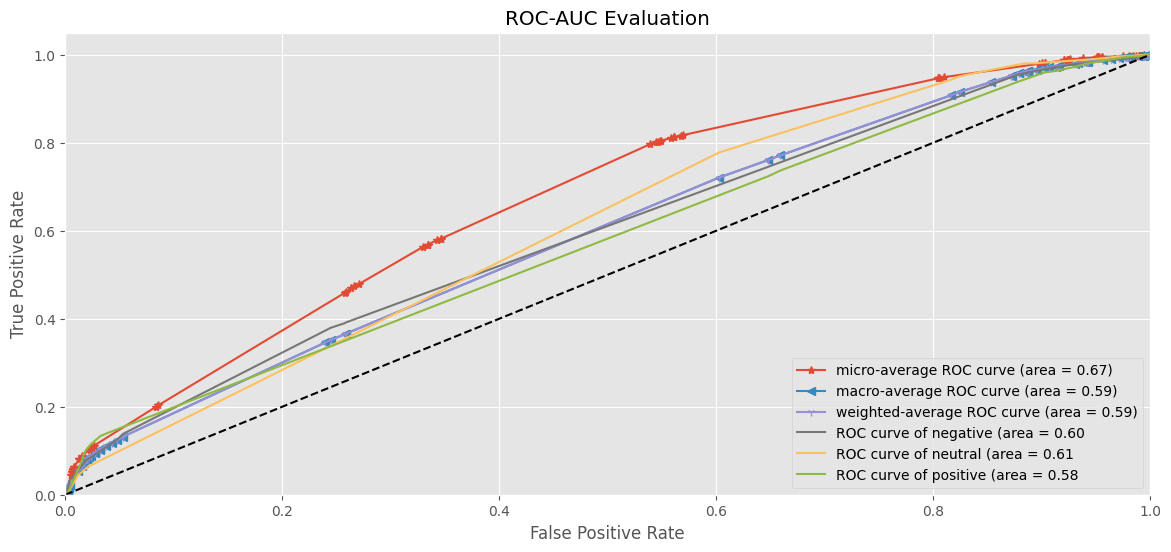

In [388]:
plot_roc_auc_curve(model, y_test_, X_test_)